# Thuật toán DUP-Apriori

Triển khai thuật toán DUP-Apriori để tìm các tập phổ biến (frequent itemsets) từ cơ sở dữ liệu giao dịch.

## Đặc điểm chính:
- Sử dụng biểu diễn bit để tối ưu hiệu suất
- Xử lý giao dịch trùng lặp hiệu quả
- Cắt tỉa không gian tìm kiếm bằng thông tin min/max

In [14]:
from collections import defaultdict, Counter
from itertools import combinations
import copy
import time

In [15]:
def create_sample_data():
    transactions = [
        ["A", "B", "C", "E", "F"],
        ["A", "C", "G"],
        ["E", "H"],
        ["A", "C", "D", "G"],
        ["A", "C", "E", "G"],
        ["E", "H"],
        ["A", "B", "C", "E", "F"],
        ["A", "C", "D"],
        ["A", "C", "E", "G"],
        ["A", "C", "E", "G"]
    ]
    return transactions

# DUP-Apriori

In [16]:
# Biến toàn cục để lưu trữ ánh xạ item -> index
item_to_index = {}

class ItemSet:
    """Cấu trúc dữ liệu cho itemset với thông tin bổ sung"""
    def __init__(self, itemset, sup=0):
        self.itemset = frozenset(itemset) if not isinstance(itemset, frozenset) else itemset
        self.sup = sup
        # Sử dụng index dựa trên thứ tự trong L1 sắp xếp theo support tăng dần
        if itemset and item_to_index:
            indices = [item_to_index[item] for item in itemset if item in item_to_index]
            self.min_item = min(indices) if indices else None
            self.max_item = max(indices) if indices else None
        else:
            # Fallback khi chưa có mapping (cho việc khởi tạo ban đầu)
            self.min_item = None
            self.max_item = None
    
    def update_min_max(self):
        """Cập nhật min/max sau khi đã có item_to_index mapping"""
        if self.itemset and item_to_index:
            indices = [item_to_index[item] for item in self.itemset if item in item_to_index]
            self.min_item = min(indices) if indices else None
            self.max_item = max(indices) if indices else None
    
    def __str__(self):
        return f"ItemSet({sorted(list(self.itemset))}, sup={self.sup:.3f}, min={self.min_item}, max={self.max_item})"
    
    def __repr__(self):
        return self.__str__()
    
    def __eq__(self, other):
        return self.itemset == other.itemset
    
    def __hash__(self):
        return hash(self.itemset)

class Transaction:
    """Cấu trúc dữ liệu cho transaction với thông tin bổ sung"""
    def __init__(self, itemset, dup=1):
        self.itemset = frozenset(itemset) if not isinstance(itemset, frozenset) else itemset
        self.length = len(self.itemset)
        # Sử dụng index dựa trên thứ tự trong L1 sắp xếp theo support tăng dần
        if itemset and item_to_index:
            indices = [item_to_index[item] for item in itemset if item in item_to_index]
            self.min_item = min(indices) if indices else None
            self.max_item = max(indices) if indices else None
        else:
            # Fallback khi chưa có mapping
            self.min_item = None
            self.max_item = None
        self.dup = dup  # số lần xuất hiện của transaction này
    
    def update_min_max(self):
        """Cập nhật min/max sau khi đã có item_to_index mapping"""
        if self.itemset and item_to_index:
            indices = [item_to_index[item] for item in self.itemset if item in item_to_index]
            self.min_item = min(indices) if indices else None
            self.max_item = max(indices) if indices else None
    
    def __str__(self):
        return f"Transaction({sorted(list(self.itemset))}, len={self.length}, min={self.min_item}, max={self.max_item}, dup={self.dup})"
    
    def __repr__(self):
        return self.__str__()
    
    def __eq__(self, other):
        return self.itemset == other.itemset
    
    def __hash__(self):
        return hash(self.itemset)

In [17]:
def apriori_gen_star(L_k_minus_1):
    """
    Thủ tục AprioriGen* để sinh ứng viên k-itemset từ (k-1)-itemset phổ biến
    
    Đầu vào: Tập chứa các (k-1)-itemset phổ biến L_{k-1}
    Đầu ra: Tập ứng viên k-itemset C_k
    """
    C_k = set()
    L_list = list(L_k_minus_1)
    
    # Sắp xếp theo min_item để tối ưu quá trình so sánh
    L_list.sort(key=lambda x: x.min_item)
    
    i = 0
    while i < len(L_list):
        j = i + 1
        
        # Vòng lặp inner theo mã giả
        while j < len(L_list):
            X_i = L_list[i]
            X_j = L_list[j]
            
            # Kiểm tra điều kiện X_i.min == X_j.min
            if X_i.min_item == X_j.min_item:
                # Tạo itemset mới từ hợp của X_i và X_j
                new_itemset = X_i.itemset.union(X_j.itemset)
                new_candidate = ItemSet(new_itemset)
                
                # Thêm vào C_k nếu chưa tồn tại (dòng 7 trong mã giả)
                if new_candidate not in C_k:
                    C_k.add(new_candidate)
                j += 1
            else:
                # Dòng 10 trong mã giả: i = j
                i = j
                break
        
        # Nếu đã duyệt hết mà không break (j đã đến cuối)
        if j == len(L_list):
            i += 1
    
    return C_k

In [18]:
def create_item_index_mapping(L1):
    """
    Tạo ánh xạ từ item sang index dựa trên thứ tự trong L1 đã sắp xếp theo support tăng dần
    """
    global item_to_index
    item_to_index = {}
    
    # Sắp xếp L1 theo support tăng dần (như trong thuật toán)
    sorted_L1 = sorted(L1, key=lambda x: x.sup)
    
    # Tạo ánh xạ item -> index (bắt đầu từ 1)
    for i, itemset in enumerate(sorted_L1, 1):
        item = list(itemset.itemset)[0]  # L1 chỉ chứa 1-itemset
        item_to_index[item] = i
    
    print(f"\nItem to index mapping (dựa trên thứ tự support tăng dần):")
    for item, idx in sorted(item_to_index.items(), key=lambda x: x[1]):
        support = next(itemset.sup for itemset in sorted_L1 if list(itemset.itemset)[0] == item)
        print(f"  {item}: index {idx} (support: {support:.3f})")
    
    return item_to_index

def sort_transactions_by_min(transactions):
    """
    Sắp xếp các giao dịch theo min_item để tối ưu hóa việc tính support
    """
    return sorted(transactions, key=lambda x: x.min_item if x.min_item is not None else float('inf'))

def preprocess_transactions(transactions):
    """
    Xử lý dữ liệu đầu vào, gộm các giao dịch trùng lặp và tạo biểu diễn bit
    """
    # Đếm số lần xuất hiện của mỗi giao dịch
    transaction_counts = Counter()
    for trans in transactions:
        frozen_trans = frozenset(trans)
        transaction_counts[frozen_trans] += 1
    
    # Tạo danh sách các transaction duy nhất với số lần xuất hiện
    unique_transactions = []
    for trans, count in transaction_counts.items():
        if len(trans) > 1:  # Chỉ giữ lại giao dịch có |t| > 1
            t = Transaction(trans, dup=count)
            # Cập nhật min/max sau khi đã có mapping
            t.update_min_max()
            unique_transactions.append(t)
    
    # Sắp xếp theo min_item để tối ưu
    return sort_transactions_by_min(unique_transactions)

def get_frequent_1_itemsets(transactions, minsup):
    """
    Tìm các 1-itemset phổ biến và sắp xếp theo support tăng dần
    """
    n = len(transactions)
    item_counts = defaultdict(int)
    
    # Đếm tần suất xuất hiện của mỗi item
    for trans in transactions:
        for item in trans:
            item_counts[item] += 1
    
    # Tạo các 1-itemset phổ biến
    L1 = []
    for item, count in item_counts.items():
        support = count / n
        if support >= minsup:
            L1.append(ItemSet([item], sup=support))
    
    # Sắp xếp theo support tăng dần
    L1.sort(key=lambda x: x.sup)
    
    return L1

In [19]:
def calculate_support(candidates, transactions, n):
    """
    Tính support cho các ứng viên dựa trên các giao dịch
    """
    for c in candidates:
        c.sup = 0
        
        # Duyệt qua các giao dịch để tính support
        i = 0
        while i < len(transactions):
            t = transactions[i]
            
            # Kiểm tra điều kiện: t.min <= c.min AND c.max <= t.max
            if t.min_item <= c.min_item and c.max_item <= t.max_item:
                # Kiểm tra c.itemset có phải là tập con của t.itemset không
                if c.itemset.issubset(t.itemset):
                    # Cải tiến chính - sử dụng t.dup
                    c.sup += t.dup / n
            
            i += 1
            
            # Tối ưu - dừng khi t[i].min > c.min
            if i < len(transactions) and transactions[i].min_item > c.min_item:
                break
    
    return candidates

def filter_frequent_itemsets(candidates, minsup):
    """
    Lọc các ứng viên thỏa mãn ngưỡng minsup
    """
    return [c for c in candidates if c.sup >= minsup]

def prune_transactions(transactions, k):
    """
    Rút gọn dữ liệu: loại bỏ các giao dịch có |t| <= k
    """
    return [t for t in transactions if t.length > k]

In [20]:
def dup_apriori(transactions, minsup):
    """
    Thuật toán DUP-Apriori chính
    
    Đầu vào: Tập giao dịch T, ngưỡng minsup
    Đầu ra: Tập phổ biến FI
    """
    n = len(transactions)
    
    # Bước 1: Tìm L1 (1-itemset phổ biến, sắp xếp tăng theo support)
    L1 = get_frequent_1_itemsets(transactions, minsup)
    
    # Tạo ánh xạ item -> index dựa trên thứ tự trong L1
    create_item_index_mapping(L1)
    
    # Cập nhật min/max cho tất cả itemsets trong L1
    for itemset in L1:
        itemset.update_min_max()
    
    # Tạo tập các item phổ biến
    frequent_items = set()
    for itemset in L1:
        frequent_items.update(itemset.itemset)
    
    # Bước 2: T1 = tập T chứa các item có trong L1 và có |t| > 1 và gộm các giao dịch trùng lặp
    # Lọc các giao dịch chỉ chứa các item phổ biến
    filtered_transactions = []
    for trans in transactions:
        filtered_items = [item for item in trans if item in frequent_items]
        if len(filtered_items) > 1:
            filtered_transactions.append(filtered_items)
    
    T1 = preprocess_transactions(filtered_transactions)
    
    print(f"\nSau khi xử lý:")
    print(f"Số transaction ban đầu: {len(transactions)}")
    print(f"Số unique transaction với |t| > 1: {len(T1)}")
    print(f"\nVí dụ các transaction sau xử lý:")
    for i, t in enumerate(T1[:5]):
        print(f"  {t}")
    
    # Bước 3: C2 = {L1 × L1} (sinh ứng viên tiềm năng 2-itemset)
    C2 = set()
    for i in range(len(L1)):
        for j in range(i + 1, len(L1)):
            new_itemset = L1[i].itemset.union(L1[j].itemset)
            candidate = ItemSet(new_itemset)
            candidate.update_min_max()  # Cập nhật min/max
            C2.add(candidate)
    
    # Bước 4: Khởi tạo k = 2
    k = 2
    Lk_minus_1 = L1
    Tk_minus_1 = T1
    Ck = C2
    FI = set(L1)  # Tập phổ biến ban đầu chứa L1
    
    # Bước 5-18: Vòng lặp chính
    while len(Lk_minus_1) >= k and Ck:  # Điều kiện dòng 18
        # Bước 6-13: Tính support cho các ứng viên
        Ck = calculate_support(list(Ck), Tk_minus_1, n)
        
        # Bước 14: Lọc ứng viên thỏa mãn
        Lk = filter_frequent_itemsets(Ck, minsup)
        
        if not Lk:  # Không còn itemset phổ biến
            break
            
        # Thêm vào tập phổ biến
        FI.update(Lk)
        
        # Bước 15: Rút gọn dữ liệu
        Tk = prune_transactions(Tk_minus_1, k)
        
        # Bước 16: Tăng k
        k += 1
        
        # Bước 17: Sinh ứng viên mới
        if len(Lk) >= k:  # Điều kiện tiếp tục theo dòng 18
            Ck = apriori_gen_star(Lk)
            # Cập nhật min/max cho các ứng viên mới
            for candidate in Ck:
                candidate.update_min_max()
        else:
            Ck = set()
        
        # Cập nhật cho lần lặp tiếp theo
        Lk_minus_1 = Lk
        Tk_minus_1 = Tk
    
    # Bước 19: Trả về FI = ⋃ₖ Lₖ
    return FI

# Run Test

In [21]:
def load_dataset(filename, max_transactions=None):
    """
    Đọc dataset từ file
    
    Đầu vào: 
    - filename: tên file dataset
    - max_transactions: giới hạn số lượng transaction để test (None = tất cả)
    
    Đầu ra: Danh sách các transaction
    """
    transactions = []
    count = 0
    
    try:
        with open(filename, 'r') as f:
            for line in f:
                if max_transactions and count >= max_transactions:
                    break
                    
                # Xử lý dòng: tách items bằng space và loại bỏ khoảng trắng
                items = line.strip().split()
                if items:  # Chỉ thêm transaction không rỗng
                    transactions.append(items)
                    count += 1
                    
    except FileNotFoundError:
        print(f"Không tìm thấy file: {filename}")
        return []
    except Exception as e:
        print(f"Lỗi khi đọc file: {e}")
        return []
    
    print(f"Đã đọc {len(transactions)} transactions từ {filename}")
    return transactions

def print_dataset_info(transactions):
    """
    In thông tin cơ bản về dataset
    """
    if not transactions:
        print("Dataset rỗng!")
        return
        
    print(f"\n=== THÔNG TIN DATASET ===")
    print(f"Số lượng transactions: {len(transactions)}")
    
    # Thống kê số lượng items duy nhất
    all_items = set()
    for trans in transactions:
        all_items.update(trans)
    print(f"Tổng số items duy nhất: {len(all_items)}")
    
    # Hiển thị một vài transaction mẫu
    print(f"\nVí dụ 5 transaction đầu tiên:")
    for i, trans in enumerate(transactions[:5]):
        print(f"  T{i+1}: {trans[:10]}{'...' if len(trans) > 10 else ''}")
    
    print("=" * 30)

In [22]:
def test_with_sample_data():
    """
    Test thuật toán với sample data
    """
    print("\n" + "="*50)
    print("TEST VỚI SAMPLE DATA")
    print("="*50)
    
    # Tạo sample data
    transactions = create_sample_data()
    print_dataset_info(transactions)
    
    # Chạy thuật toán với các minsup khác nhau
    minsup_values = [0.3, 0.4, 0.5]
    
    for minsup in minsup_values:
        print(f"\n--- CHẠY VỚI MINSUP = {minsup} ---")
        
        start_time = time.time()
        frequent_itemsets = dup_apriori(transactions, minsup)
        end_time = time.time()
        
        print(f"Thời gian thực hiện: {end_time - start_time:.4f} giây")
        print(f"Số lượng frequent itemsets tìm được: {len(frequent_itemsets)}")
        
        # Sắp xếp theo kích thước itemset và support
        sorted_itemsets = sorted(frequent_itemsets, key=lambda x: (len(x.itemset), -x.sup))
        
        print("\nCác frequent itemsets tìm được:")
        current_size = 0
        for itemset in sorted_itemsets:
            if len(itemset.itemset) != current_size:
                current_size = len(itemset.itemset)
                print(f"\n  {current_size}-itemsets:")
            print(f"    {sorted(list(itemset.itemset))} (support: {itemset.sup:.3f})")

# Chạy test với sample data
test_with_sample_data()


TEST VỚI SAMPLE DATA

=== THÔNG TIN DATASET ===
Số lượng transactions: 10
Tổng số items duy nhất: 8

Ví dụ 5 transaction đầu tiên:
  T1: ['A', 'B', 'C', 'E', 'F']
  T2: ['A', 'C', 'G']
  T3: ['E', 'H']
  T4: ['A', 'C', 'D', 'G']
  T5: ['A', 'C', 'E', 'G']

--- CHẠY VỚI MINSUP = 0.3 ---

Item to index mapping (dựa trên thứ tự support tăng dần):
  G: index 1 (support: 0.500)
  E: index 2 (support: 0.700)
  A: index 3 (support: 0.800)
  C: index 4 (support: 0.800)

Sau khi xử lý:
Số transaction ban đầu: 10
Số unique transaction với |t| > 1: 4

Ví dụ các transaction sau xử lý:
  Transaction(['A', 'C', 'G'], len=3, min=1, max=4, dup=2)
  Transaction(['A', 'C', 'E', 'G'], len=4, min=1, max=4, dup=3)
  Transaction(['A', 'C', 'E'], len=3, min=2, max=4, dup=2)
  Transaction(['A', 'C'], len=2, min=3, max=4, dup=1)
Thời gian thực hiện: 0.0027 giây
Số lượng frequent itemsets tìm được: 13

Các frequent itemsets tìm được:

  1-itemsets:
    ['A'] (support: 0.800)
    ['C'] (support: 0.800)
    ['E'

In [23]:
def test_with_retail_dataset(max_transactions=1000, minsup=0.01):
    """
    Test thuật toán với dataset retail.txt
    
    Đầu vào:
    - max_transactions: giới hạn số transaction để test
    - minsup: ngưỡng support tối thiểu
    """
    print("\n" + "="*50)
    print(f"TEST VỚI RETAIL DATASET (giới hạn {max_transactions} transactions)")
    print("="*50)
    
    # Đọc dataset
    transactions = load_dataset('retail.txt', max_transactions)
    
    if not transactions:
        print("Không thể đọc dataset!")
        return
    
    print_dataset_info(transactions)
    
    print(f"\n--- CHẠY VỚI MINSUP = {minsup} ---")
    
    start_time = time.time()
    frequent_itemsets = dup_apriori(transactions, minsup)
    end_time = time.time()
    
    print(f"Thời gian thực hiện: {end_time - start_time:.4f} giây")
    print(f"Số lượng frequent itemsets tìm được: {len(frequent_itemsets)}")
    
    # Thống kê theo kích thước itemset
    size_counts = defaultdict(int)
    for itemset in frequent_itemsets:
        size_counts[len(itemset.itemset)] += 1
    
    print("\nThống kê theo kích thước:")
    for size in sorted(size_counts.keys()):
        print(f"  {size}-itemsets: {size_counts[size]} tập")
    
    # Hiển thị top 10 itemsets có support cao nhất
    sorted_itemsets = sorted(frequent_itemsets, key=lambda x: -x.sup)[:10]
    print("\nTop 10 frequent itemsets có support cao nhất:")
    for i, itemset in enumerate(sorted_itemsets, 1):
        items_str = ', '.join(sorted(list(itemset.itemset)))
        print(f"  {i}. {{{items_str}}} (support: {itemset.sup:.4f})")

# Test với dataset retail (bắt đầu với 1000 transactions)
test_with_retail_dataset(max_transactions=1000, minsup=0.01)


TEST VỚI RETAIL DATASET (giới hạn 1000 transactions)
Đã đọc 1000 transactions từ retail.txt

=== THÔNG TIN DATASET ===
Số lượng transactions: 1000
Tổng số items duy nhất: 3182

Ví dụ 5 transaction đầu tiên:
  T1: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']...
  T2: ['31', '32', '33']
  T3: ['34', '35', '36']
  T4: ['37', '38', '39', '40', '41', '42', '43', '44', '45', '46']...
  T5: ['39', '40', '48', '49']

--- CHẠY VỚI MINSUP = 0.01 ---

Item to index mapping (dựa trên thứ tự support tăng dần):
  46: index 1 (support: 0.010)
  48: index 2 (support: 0.010)
  56: index 3 (support: 0.010)
  77: index 4 (support: 0.010)
  96: index 5 (support: 0.010)
  186: index 6 (support: 0.010)
  202: index 7 (support: 0.010)
  209: index 8 (support: 0.010)
  243: index 9 (support: 0.010)
  536: index 10 (support: 0.010)
  613: index 11 (support: 0.010)
  695: index 12 (support: 0.010)
  957: index 13 (support: 0.010)
  1394: index 14 (support: 0.010)
  12: index 15 (support: 0.011)
  265: i

In [24]:
def performance_comparison():
    """
    So sánh hiệu suất với các kích thước dataset khác nhau
    """
    print("\n" + "="*60)
    print("SO SÁNH HIỆU SUẤT VỚI CÁC KÍCH THƯỚC DATASET KHÁC NHAU")
    print("="*60)
    
    # Các kích thước dataset để test
    sizes = [500, 1000, 2000, 5000]
    minsup = 0.01
    
    results = []
    
    for size in sizes:
        print(f"\n--- TEST VỚI {size} TRANSACTIONS ---")
        
        # Đọc dataset
        transactions = load_dataset('retail.txt', max_transactions=size)
        
        if not transactions:
            print(f"Không thể đọc {size} transactions!")
            continue
            
        # Chạy thuật toán
        start_time = time.time()
        frequent_itemsets = dup_apriori(transactions, minsup)
        end_time = time.time()
        
        runtime = end_time - start_time
        num_itemsets = len(frequent_itemsets)
        
        results.append({
            'size': size,
            'runtime': runtime,
            'itemsets': num_itemsets
        })
        
        print(f"Thời gian: {runtime:.4f}s | Frequent itemsets: {num_itemsets}")
    
    # Tóm tắt kết quả
    print("\n" + "="*40)
    print("TÓM TẮT KẾT QUẢ")
    print("="*40)
    print(f"{'Kích thước':<12} {'Thời gian (s)':<15} {'Itemsets':<10}")
    print("-" * 40)
    
    for result in results:
        print(f"{result['size']:<12} {result['runtime']:<15.4f} {result['itemsets']:<10}")

# Chạy so sánh hiệu suất (có thể mất vài phút)
# perfornce_comparison()

In [25]:
# Test với dataset lớn hơn
print("Test với 5000 transactions từ retail.txt:")
test_with_retail_dataset(max_transactions=None, minsup=0.01)

Test với 5000 transactions từ retail.txt:

TEST VỚI RETAIL DATASET (giới hạn None transactions)
Đã đọc 88162 transactions từ retail.txt

=== THÔNG TIN DATASET ===
Số lượng transactions: 88162
Tổng số items duy nhất: 16470

Ví dụ 5 transaction đầu tiên:
  T1: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']...
  T2: ['31', '32', '33']
  T3: ['34', '35', '36']
  T4: ['37', '38', '39', '40', '41', '42', '43', '44', '45', '46']...
  T5: ['39', '40', '48', '49']

--- CHẠY VỚI MINSUP = 0.01 ---

Item to index mapping (dựa trên thứ tự support tăng dần):
  10516: index 1 (support: 0.010)
  265: index 2 (support: 0.010)
  2959: index 3 (support: 0.010)
  46: index 4 (support: 0.010)
  243: index 5 (support: 0.010)
  957: index 6 (support: 0.010)
  32: index 7 (support: 0.010)
  480: index 8 (support: 0.011)
  3271: index 9 (support: 0.011)
  784: index 10 (support: 0.011)
  176: index 11 (support: 0.011)
  523: index 12 (support: 0.011)
  259: index 13 (support: 0.011)
  180: index 14 (suppo


BIỂU ĐỒ HIỆU SUẤT TRÊN TOÀN BỘ DATASET RETAIL
Đang đọc toàn bộ dataset retail.txt...
Đã đọc 88162 transactions từ retail.txt

=== THÔNG TIN DATASET ===
Số lượng transactions: 88162
Tổng số items duy nhất: 16470

Ví dụ 5 transaction đầu tiên:
  T1: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']...
  T2: ['31', '32', '33']
  T3: ['34', '35', '36']
  T4: ['37', '38', '39', '40', '41', '42', '43', '44', '45', '46']...
  T5: ['39', '40', '48', '49']

Bắt đầu chạy thuật toán với các minsup khác nhau...
(Lưu ý: Quá trình này có thể mất vài phút)

[1/5] Đang chạy với minsup = 0.2...

Item to index mapping (dựa trên thứ tự support tăng dần):
  49: index 1 (support: 0.478)
  40: index 2 (support: 0.575)

Sau khi xử lý:
Số transaction ban đầu: 88162
Số unique transaction với |t| > 1: 1

Ví dụ các transaction sau xử lý:
  Transaction(['40', '49'], len=2, min=1, max=2, dup=29142)
  ✓ Hoàn thành trong 347ms | 3 frequent itemsets

[2/5] Đang chạy với minsup = 0.3...

Item to index mapping (dựa 

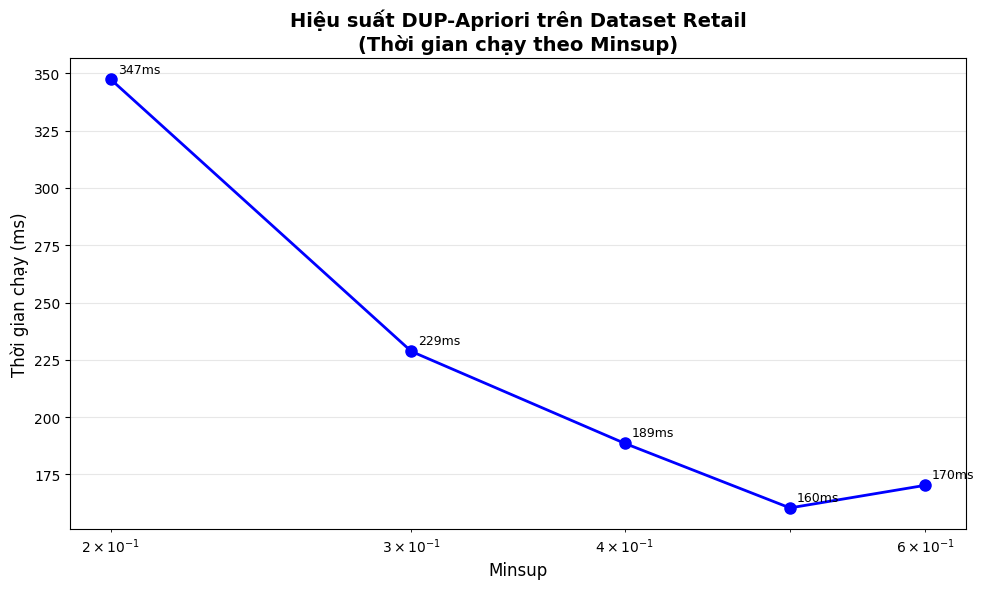


KẾT QUẢ CHI TIẾT
Minsup     Thời gian (ms)  Itemsets     Hiệu suất      
-------------------------------------------------------
0.2        347             3            0.0086         
0.3        229             3            0.0131         
0.4        189             2            0.0106         
0.5        160             1            0.0062         
0.6        170             0            0.0000         


In [26]:
import matplotlib.pyplot as plt
import numpy as np

def create_performance_graph():
    """
    Tạo biểu đồ hiệu suất chạy thuật toán DUP-Apriori 
    trên toàn bộ dataset retail với các minsup khác nhau
    """
    print("\n" + "="*60)
    print("BIỂU ĐỒ HIỆU SUẤT TRÊN TOÀN BỘ DATASET RETAIL")
    print("="*60)
    
    # Đọc toàn bộ dataset retail
    print("Đang đọc toàn bộ dataset retail.txt...")
    transactions = load_dataset('retail.txt')  # Không giới hạn số lượng
    
    if not transactions:
        print("Không thể đọc dataset!")
        return
        
    print_dataset_info(transactions)
    
    # Các giá trị minsup để test (từ cao xuống thấp để tránh timeout)
    minsup_values = [0.2, 0.3, 0.4, 0.5, 0.6]
    runtimes = []
    itemset_counts = []
    
    print("\nBắt đầu chạy thuật toán với các minsup khác nhau...")
    print("(Lưu ý: Quá trình này có thể mất vài phút)")
    
    for i, minsup in enumerate(minsup_values):
        print(f"\n[{i+1}/{len(minsup_values)}] Đang chạy với minsup = {minsup}...")
        
        try:
            start_time = time.time()
            frequent_itemsets = dup_apriori(transactions, minsup)
            end_time = time.time()
            
            runtime = (end_time - start_time) * 1000  # đổi sang mili giây
            num_itemsets = len(frequent_itemsets)
            
            runtimes.append(runtime)
            itemset_counts.append(num_itemsets)
            
            print(f"  ✓ Hoàn thành trong {runtime:.0f}ms | {num_itemsets} frequent itemsets")
            
        except Exception as e:
            print(f"  ✗ Lỗi: {e}")
            runtimes.append(None)
            itemset_counts.append(None)
    
    # Lọc bỏ các giá trị None (lỗi)
    valid_data = [(minsup, runtime, count) for minsup, runtime, count in 
                  zip(minsup_values, runtimes, itemset_counts) 
                  if runtime is not None]
    
    if not valid_data:
        print("Không có dữ liệu hợp lệ để vẽ biểu đồ!")
        return
    
    valid_minsup, valid_runtime, valid_counts = zip(*valid_data)
    
    # Tạo biểu đồ: chỉ giữ biểu đồ thời gian chạy vs Minsup
    plt.figure(figsize=(10, 6))
    plt.plot(valid_minsup, valid_runtime, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Minsup', fontsize=12)
    plt.ylabel('Thời gian chạy (ms)', fontsize=12)
    plt.title('Hiệu suất DUP-Apriori trên Dataset Retail\n(Thời gian chạy theo Minsup)', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xscale('log')  # Scale logarit cho minsup
    
    # Thêm annotations cho các điểm
    for minsup, runtime in zip(valid_minsup, valid_runtime):
        plt.annotate(f'{runtime:.0f}ms', 
                    xy=(minsup, runtime), 
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # In bảng tóm tắt kết quả
    print("\n" + "="*50)
    print("KẾT QUẢ CHI TIẾT")
    print("="*50)
    print(f"{'Minsup':<10} {'Thời gian (ms)':<15} {'Itemsets':<12} {'Hiệu suất':<15}")
    print("-" * 55)
    
    for minsup, runtime, count in valid_data:
        efficiency = count / runtime if runtime > 0 else 0
        print(f"{minsup:<10} {runtime:<15.0f} {count:<12} {efficiency:<15.4f}")
    
# Chạy biểu đồ hiệu suất
create_performance_graph()
